In [1]:
from rl.environments.AbstractConveyor import AbstractConveyor
import yaml
from stable_baselines import PPO2
from stable_baselines.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import rl.helpers
import cv2
import math
import random
import statistics as sts
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd


config_path = 'rl/config/AbstractConveyor.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
env = AbstractConveyor(config)

print('Model Parameters are: \n')
print('\t Queue length:\t\t\t{} \n \t Pipeline length: \t\t{}'.format(env.gtp_buffer_length, env.pipeline_length))
print('\t Amount GtP:\t\t\t{} \n \t Types of order carriers: \t{}'.format(env.amount_of_gtps, env.amount_of_outputs))
print('\t To process orders:\t\t{}/{} \n \t Termination condition: \t{}\n'.format(env.max_items_processed, env.amount_of_gtps*env.gtp_demand_size, env.termination_condition))
env.render_plt()

INFO:tensorflow:TensorFlow


Model Parameters are: 

	 Queue length:			7 
 	 Pipeline length: 		10
	 Amount GtP:			5 
 	 Types of order carriers: 	3
	 To process orders:		250/500 
 	 Termination condition: 	3



<Figure size 640x480 with 1 Axes>

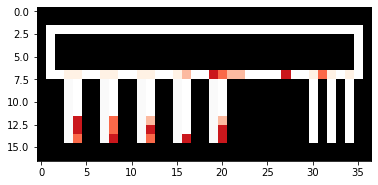

In [17]:
env.do_heuristic_guided_step()
env.render_plt()

In [2]:
def do_heuristic_guided_step(bezetgr=0.30):
    """
    Sets a step in the environment based on the 
    """
    order_sequence = []                                             #we build a FiFo list here
    for idx, queue in enumerate(env.in_queue[::-1]):                #reversed, because you want to service the last queue first
        if len(queue) +len(env.in_pipe[::-1][idx]) < 0.5 * env.gtp_buffer_length+ (env.pipeline_length//15):
            try:
                current_demand = [item for item in env.init_queues[::-1]][idx][len(env.in_pipe[::-1][idx]):][0]
                order_sequence.append((current_demand,len(env.in_queue)-idx))
            except:
                pass
    try:
        order_type, goal = order_sequence[0]
    except:
        order_type, goal = 0, 0

    env.step(None, order_type, goal)
    
def plot_from_dict(data_dict, topic):
    """
    builds plot with the idle time and the recirculation factor
    """
    #plot in a plotly graph
    data = pd.DataFrame.from_dict(data_dict).T.reset_index()
    data['index'] = data['index'].str.replace('lane_l_','buffersize=')
    data['index'] = data['index'].str.replace('pipel_','')

    fig = make_subplots(rows=2, cols=1)
    fig.append_trace(go.Scatter(
        x=data['index'],
        y=data.idle_time,
        name='Idle time operators'
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        x=data['index'],
        y=data.cycle_count,
        name='Recirculation carriers'
    ), row=2, col=1, )

    fig.update_layout(
        height=600, 
        width=1000, 
        title_text="Influence of {} on idle time and re-circulation".format(topic),
                     )
    fig.show()

In [107]:
# Run 100 episodes to test this initial setup
no_episodes = 100

# idle_time = []
# cycle_count = []
# steps = []

results = {}
results['idle_time'] = 0
results['cycle_count'] = 0
results['steps'] = 0

for episode in range(no_episodes):
    print('episode: {} \t steps: \t {}'.format(episode, env.steps), end='\r')
    env.reset()
    while not env.terminate:
        do_heuristic_guided_step()
#     idle_time.append(sum(env.idle_times_operator.values()))
#     cycle_count.append(env.cycle_count)
#     steps.append(env.steps)
    results['idle_time'] += sum(env.idle_times_operator.values())
    results['cycle_count'] += env.cycle_count
    results['steps'] += env.steps
    
# print('Mean idle time of operators over {} episodes: \t {}'.format(no_episodes, sts.mean(idle_time)))
# print('Mean cycle_count of carriers over {} episodes: \t {}%'.format(no_episodes, sts.mean(cycle_count)))
# print('Average of {} steps per episode.'.format(sts.mean(steps)))

print('Mean idle time of operators over {} episodes: \t {}'.format(no_episodes, results['idle_time'] / no_episodes))
print('Mean cycle_count of carriers over {} episodes:\t {}%'.format(no_episodes, results['cycle_count'] / no_episodes))
print('Average of \t{} \t steps per episode.'.format(results['steps'] / no_episodes))

Mean idle time of operators over 100 episodes: 	 1.79
Mean cycle_count of carriers over 100 episodes:	 0.14%
Average of 1668.5 steps per episode.


In [ ]:
#run 1 episode with render to visually check the performance
env.reset()
while not env.terminate:
    do_heuristic_guided_step()
    env.render()

# Check for effect on changing the GTP buffer length

In [109]:
#we decrease the bufferlane length for each run
max_length = 10
no_episodes = 50

diff_lane_r = {}

config_path = 'rl/config/AbstractConveyor.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

for lane_l in range(1,max_length+1)[::-1]:                #decending
    
    config['environment']['gtp_buffer_length'] = lane_l
    env = AbstractConveyor(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('lane length: {} \t episode: {} \t steps: \t {}'.format(lane_l, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            do_heuristic_guided_step()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_lane_r['lane_l_{}'.format(lane_l)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }
    

In [110]:
plot_from_dict(diff_lane_r, 'GtP-buffer length')

# Check for the influence of pipeline length

In [111]:
#we decrease the bufferlane length for each run
max_length = 100
stepsize = 5
no_episodes = 50

config_path = 'rl/config/AbstractConveyor.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
diff_pipe_r = {}

for pipe_l in range(5,max_length, stepsize):                #ascending
    
    config['environment']['pipeline_length'] = pipe_l
    env = AbstractConveyor(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('pipeline length: {} \t episode: {} \t steps: \t {}'.format(pipe_l, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            do_heuristic_guided_step()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_pipe_r['pipel_{}'.format(pipe_l)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }
    

In [112]:
plot_from_dict(diff_pipe_r, 'pipeline length')

# For the effect on speed increase by operators

In [120]:
#we decrease the bufferlane length for each run
max_improvement = 40 #procent
stepsize = 2
no_episodes = 50

config_path = 'rl/config/AbstractConveyor.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
diff_speed_r = {}

for speed in range(0,max_improvement+stepsize, stepsize):
    speed_imp = speed/100
    
    config['environment']['speed_improvement'] = speed_imp
    env = AbstractConveyor(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('Operator speed improvement: {} \t episode: {} \t steps: \t {}'.format(speed_imp, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            do_heuristic_guided_step()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_speed_r['impr_{}'.format(speed_imp)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }
    

In [121]:
plot_from_dict(diff_speed_r, 'operator speed improvement')

# influence of the amount of GtP on the errors

In [123]:
#we decrease the bufferlane length for each run
max_improvement = 15 
stepsize = 2
no_episodes = 50

config_path = 'rl/config/AbstractConveyor.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
diff_gtp_no_r = {}

for gtp_no in range(3,max_improvement+stepsize, stepsize):
    
    config['environment']['amount_of_gtps'] = gtp_no
    env = AbstractConveyor(config)
    results = {}
    results['idle_time'] = 0
    results['cycle_count'] = 0
    results['steps'] = 0

    for episode in range(no_episodes):
        print('Amount of gtp: {} \t episode: {} \t steps: \t {}'.format(gtp_no, episode, env.steps), end='\r')
        env.reset()
        while not env.terminate:
            do_heuristic_guided_step()
        results['idle_time'] += sum(env.idle_times_operator.values())
        results['cycle_count'] += env.cycle_count
        results['steps'] += env.steps
    
    diff_gtp_no_r['gtp_no_{}'.format(gtp_no)] = {
        'idle_time' : results['idle_time']/no_episodes,
        'cycle_count' : results['cycle_count']/no_episodes,
        'steps' : results['steps']/no_episodes
    }
    

In [124]:
plot_from_dict(diff_gtp_no_r, 'amount of gtp')